# 1. Import Libraries

In [229]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from datetime import datetime

# 2. Load the Dataset

In [230]:
path = '/content/laptop_price - dataset.csv'
dataset = pd.read_csv(path)
print("Dataset Loaded:\n", dataset.head())

Dataset Loaded:
   Company      Product   TypeName  Inches  ...                GPU_Type  OpSys Weight (kg)  Price (Euro)
0   Apple  MacBook Pro  Ultrabook    13.3  ...  Iris Plus Graphics 640  macOS        1.37       1339.69
1   Apple  Macbook Air  Ultrabook    13.3  ...        HD Graphics 6000  macOS        1.34        898.94
2      HP       250 G6   Notebook    15.6  ...         HD Graphics 620  No OS        1.86        575.00
3   Apple  MacBook Pro  Ultrabook    15.4  ...          Radeon Pro 455  macOS        1.83       2537.45
4   Apple  MacBook Pro  Ultrabook    13.3  ...  Iris Plus Graphics 650  macOS        1.37       1803.60

[5 rows x 15 columns]


In [231]:
print(dataset.shape)

(1275, 15)


In [232]:
print(dataset.isnull().sum())

Company                0
Product                0
TypeName               0
Inches                 0
ScreenResolution       0
CPU_Company            0
CPU_Type               0
CPU_Frequency (GHz)    0
RAM (GB)               0
Memory                 0
GPU_Company            0
GPU_Type               0
OpSys                  0
Weight (kg)            0
Price (Euro)           0
dtype: int64


In [233]:
print(dataset.dtypes)

Company                 object
Product                 object
TypeName                object
Inches                 float64
ScreenResolution        object
CPU_Company             object
CPU_Type                object
CPU_Frequency (GHz)    float64
RAM (GB)                 int64
Memory                  object
GPU_Company             object
GPU_Type                object
OpSys                   object
Weight (kg)            float64
Price (Euro)           float64
dtype: object


# 3. Preprocess the Dataset

In [234]:
def preprocess_dataset(dataset, target_columns):

    # Encode categorical variables
    le = LabelEncoder()

    for column in dataset.select_dtypes(include=['object']).columns:
        dataset[column] = le.fit_transform(dataset[column])

    # Split dataset
    X = dataset.drop(columns=target_columns, axis=1)  # Features
    y = dataset[target_columns] # Target
    X = X.to_numpy()
    y = y.to_numpy().reshape(-1, 1)

    sc = MinMaxScaler()
    X = sc.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test

In [235]:
X_train, X_test, y_train, y_test = preprocess_dataset(dataset, target_columns=['Price (Euro)'])
print("Data Preprocessing Completed.")

Data Preprocessing Completed.


In [236]:
print(dataset.dtypes)

Company                  int64
Product                  int64
TypeName                 int64
Inches                 float64
ScreenResolution         int64
CPU_Company              int64
CPU_Type                 int64
CPU_Frequency (GHz)    float64
RAM (GB)                 int64
Memory                   int64
GPU_Company              int64
GPU_Type                 int64
OpSys                    int64
Weight (kg)            float64
Price (Euro)           float64
dtype: object


# 4. Utilities

In [237]:
def plot_result(y_test, y_pred):
    plt.plot(y_test, color='red', label='Ground Truth')
    plt.plot(y_pred, color='blue', label='Predicted')
    plt.legend(loc='upper left')

In [238]:
def find_best_alpha(X_train, y_train, X_test, y_test):
    alpha_values = np.logspace(-4, 4, 100)
    best_alpha = 0
    best_r2 = 0
    r2_values = []

    for alpha in alpha_values:
        lr = Ridge(alpha=alpha)
        lr.fit(X_train, y_train)

        y_pred = lr.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        r2_values.append(r2)

        if r2 > best_r2:
            best_r2 = r2
            best_alpha = alpha

    plt.plot(alpha_values, r2_values, color='red')
    plt.xlabel("alpha")
    plt.ylabel("r2 score")
    plt.title(f"R2 Scores (Best R2 score = {best_r2:.4f} at alpha = {best_alpha})")

    return best_r2 ,best_alpha

In [239]:
def find_best_tau(X_train, y_train, X_test, y_test):
    tau_values = np.logspace(-4, 4, 100)
    best_tau = 0
    best_r2 = 0
    r2_values = []

    for tau in tau_values:
        lr = CustomRidge(tau=tau)
        lr.fit(X_train, y_train)

        y_pred = lr.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        r2_values.append(r2)

        if r2 > best_r2:
            best_r2 = r2
            best_tau = tau

    plt.plot(tau_values, r2_values, color='red')
    plt.xlabel("tau")
    plt.ylabel("r2 score")
    plt.title(f"R2 Scores (Best R2 score = {best_r2:.4f} at tau = {best_tau})")

    return best_r2 ,best_tau

# 5. Reference Linear Regressor

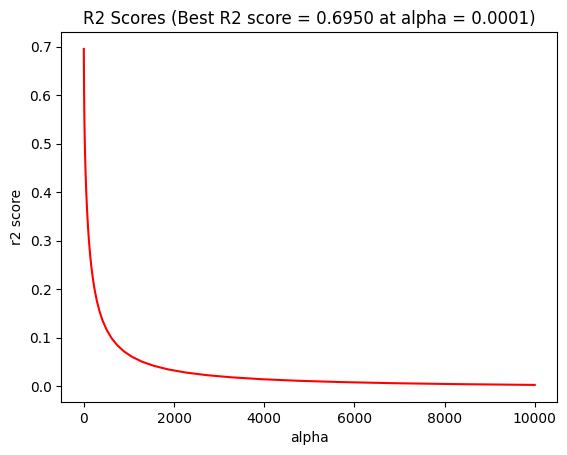

In [240]:
best_r2 ,best_alpha = find_best_alpha(X_train, y_train, X_test, y_test)

In [241]:
lr_ref = Ridge(alpha=best_alpha)
lr_ref.fit(X_train, y_train)

Ridge(alpha=0.0001)

In [242]:
start_time = datetime.now()

y_pred = lr_ref.predict(X_test)

end_time = datetime.now()

# Metrics
r2 = r2_score(y_test, y_pred)

print(f"\nReference Linear Regressor")
print(f"\nExecution Time: {(end_time - start_time).microseconds} mcs")
print(f"\nR2 score: {r2:.4f}")


Reference Linear Regressor

Execution Time: 678 mcs

R2 score: 0.6950


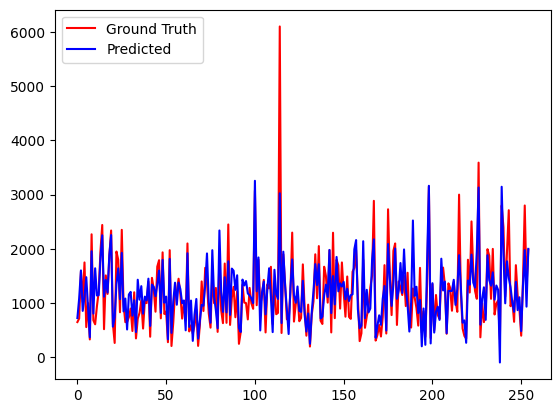

In [243]:
plot_result(y_test, y_pred)

# 6. Custom Linear Regressor

In [244]:
class CustomRidge:
    def __init__(self, tau=0):
        self.tau = tau
        self.best_weight = None

    def svd(self, X):
        return np.linalg.svd(X, full_matrices=False)

    def fit(self, X, y):
        V, D, Ut = self.svd(X)

        if self.tau == 0:
            F_pseudo = Ut.T @ np.linalg.inv(np.diag(D)) @ V.T
            self.best_weight = F_pseudo @ y
        else:
            self.best_weight = Ut.T @ np.linalg.inv(np.diag(D ** 2) + self.tau * np.eye(D.shape[0])) @ np.diag(D) @ V.T @ y

    def predict(self, X):
        return X @ self.best_weight

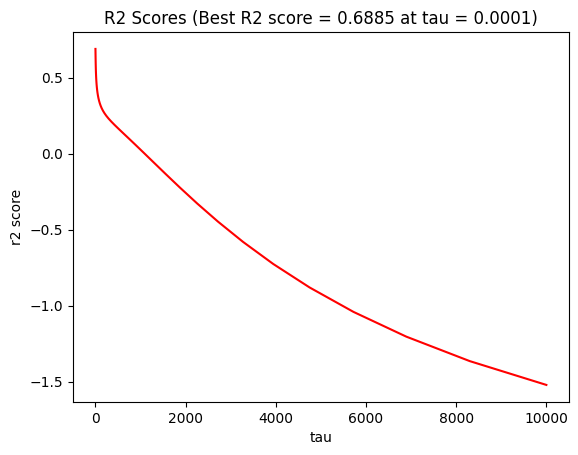

In [245]:
best_r2 ,best_tau = find_best_tau(X_train, y_train, X_test, y_test)

In [246]:
lr_cus = CustomRidge(tau=best_tau)
lr_cus.fit(X_train, y_train)

In [247]:
start_time = datetime.now()

y_pred = lr_cus.predict(X_test)

end_time = datetime.now()

# Metrics
r2 = r2_score(y_test, y_pred)

print(f"\nCustom Linear Regressor")
print(f"\nExecution Time: {(end_time - start_time).microseconds} mcs")
print(f"\nR2 score: {r2:.4f}")


Custom Linear Regressor

Execution Time: 148 mcs

R2 score: 0.6885


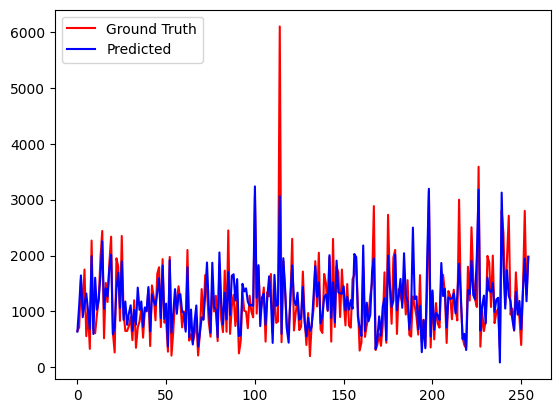

In [248]:
plot_result(y_test, y_pred)